<a href="https://colab.research.google.com/github/russmendez/DS_notebooks/blob/master/Recommender_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Netflix wants to identify similar movies based on movie characteristics.
   

#Loading the data

According to the description from kaggel:

This dataset consists of tv shows and movies available on Netflix as of 2019. The dataset is collected from Flixable which is a third-party Netflix search engine.

The goal of this project is to identify similar movies and shows based on their characteristics.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import umap
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from sklearn import datasets, metrics

from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split 

from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN

!pip install rake_nltk
#The install code needs to be run everytime. Why is that?
from rake_nltk import Rake

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer

  Created wheel for rake-nltk: filename=rake_nltk-1.0.4-py2.py3-none-any.whl size=7819 sha256=919674cc1776650efda53d515ef11024f10068152689d2b46a01eaf38b6e3fd1
  Stored in directory: /root/.cache/pip/wheels/ef/92/fc/271b3709e71a96ffe934b27818946b795ac6b9b8ff8682483f
Successfully built rake-nltk


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
#!unzip '/content/drive/My Drive/archive (3).zip' -d '/content/drive/My Drive/'
netflix_df = pd.read_csv('drive/My Drive/netflix_titles.csv')

Mounted at /content/drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
#!unzip '/content/drive/My Drive/archive (4).zip' -d '/content/drive/My Drive/'
master_movie_df = pd.read_csv('drive/My Drive/MoviesOnStreamingPlatforms_updated.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
netflix_df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,81145628,Movie,Norm of the North: King Sized Adventure,"Richard Finn, Tim Maltby","Alan Marriott, Andrew Toth, Brian Dobson, Cole...","United States, India, South Korea, China","September 9, 2019",2019,TV-PG,90 min,"Children & Family Movies, Comedies",Before planning an awesome wedding for his gra...
1,80117401,Movie,Jandino: Whatever it Takes,NaN,Jandino Asporaat,United Kingdom,"September 9, 2016",2016,TV-MA,94 min,Stand-Up Comedy,Jandino Asporaat riffs on the challenges of ra...
2,70234439,TV Show,Transformers Prime,NaN,"Peter Cullen, Sumalee Montano, Frank Welker, J...",United States,"September 8, 2018",2013,TV-Y7-FV,1 Season,Kids' TV,"With the help of three human allies, the Autob..."
3,80058654,TV Show,Transformers: Robots in Disguise,NaN,"Will Friedle, Darren Criss, Constance Zimmer, ...",United States,"September 8, 2018",2016,TV-Y7,1 Season,Kids' TV,When a prison ship crash unleashes hundreds of...
4,80125979,Movie,#realityhigh,Fernando Lebrija,"Nesta Cooper, Kate Walsh, John Michael Higgins...",United States,"September 8, 2017",2017,TV-14,99 min,Comedies,When nerdy high schooler Dani finally attracts...


In [ ]:
netflix_df['title']

0           Norm of the North: King Sized Adventure
1                        Jandino: Whatever it Takes
2                                Transformers Prime
3                  Transformers: Robots in Disguise
4                                      #realityhigh
                           ...                     
6229                                   Red vs. Blue
6230                                          Maron
6231         Little Baby Bum: Nursery Rhyme Friends
6232    A Young Doctor's Notebook and Other Stories
6233                                        Friends
Name: title, Length: 6234, dtype: object

In [ ]:
netflix_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6234 entries, 0 to 6233
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       6234 non-null   int64 
 1   type          6234 non-null   object
 2   title         6234 non-null   object
 3   director      4265 non-null   object
 4   cast          5664 non-null   object
 5   country       5758 non-null   object
 6   date_added    6223 non-null   object
 7   release_year  6234 non-null   int64 
 8   rating        6224 non-null   object
 9   duration      6234 non-null   object
 10  listed_in     6234 non-null   object
 11  description   6234 non-null   object
dtypes: int64(2), object(10)
memory usage: 584.6+ KB


In [ ]:
netflix_df.isna().sum()/netflix_df.count()*100

show_id          0.000000
type             0.000000
title            0.000000
director        46.166471
cast            10.063559
country          8.266759
date_added       0.176764
release_year     0.000000
rating           0.160668
duration         0.000000
listed_in        0.000000
description      0.000000
dtype: float64

There are 12 columns to work with in this dataset. The director column is 46% empty and poses the greatest limitation in terms of NaN values. Cast and country are 10% and 8% NaN, respectively. However, for our purposes, this may not be significant.

#EDA/Data Cleaning/Feature Engineering



Distribution of type

The data is about 2/3 movies and 1/3 TV shows. 

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


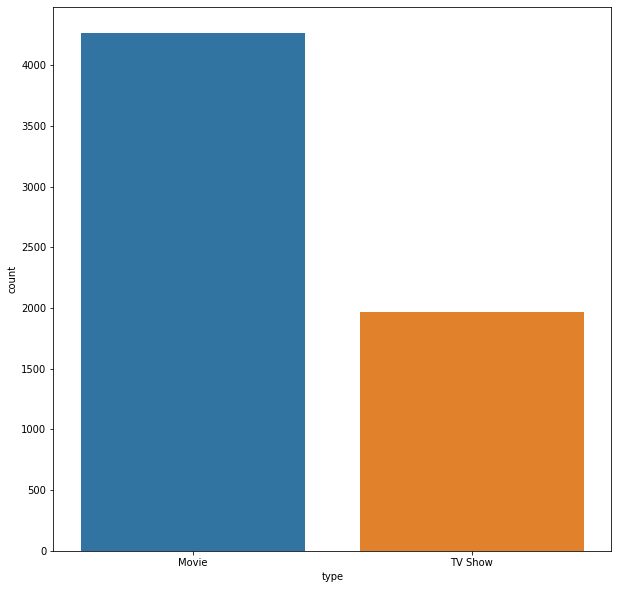

In [ ]:
figure = plt.figure(figsize=(10,10))
sns.countplot(netflix_df['type'])

Distribution of rating.

The largest group of ratings is TV-MA. An interesting point to note is that only 1017 'Movies' are rated with the movie style rating system: G, PG, PG-13, R, and NC-17. This means the remaining 'Movies' must be rated with the TV rating system.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 <a list of 14 Text major ticklabel objects>)

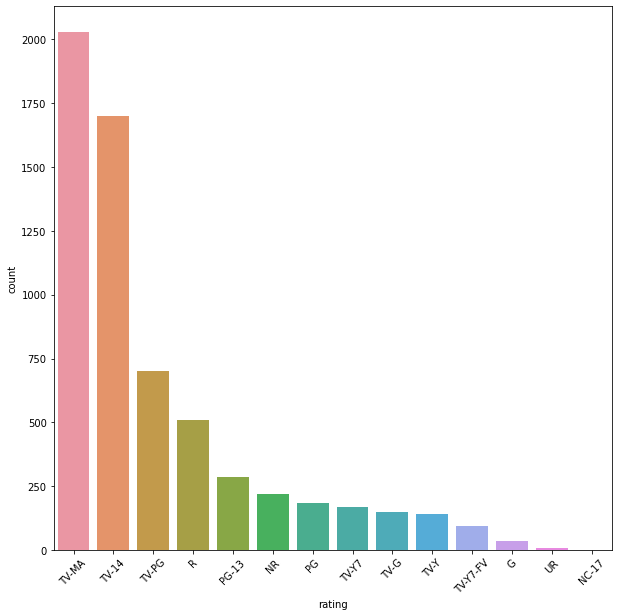

In [ ]:
figure = plt.figure(figsize=(10,10))
sns.countplot(x = netflix_df['rating'].dropna(), order=netflix_df['rating'].dropna().value_counts().index)
plt.xticks(rotation=45)

In [ ]:
netflix_df['rating'].dropna().unique()

array(['TV-PG', 'TV-MA', 'TV-Y7-FV', 'TV-Y7', 'TV-14', 'R', 'TV-Y', 'NR',
       'PG-13', 'TV-G', 'PG', 'G', 'UR', 'NC-17'], dtype=object)

In [ ]:
len(netflix_df[netflix_df['rating'].isin(['NC-17','R', 'PG-13', 'PG', 'G'])])

1017

#Recommender 1 - netflix_df

### Content Based Filtering 

In this recommender system I use cast, director, listen_in(genre), description, and rating. More of the columns could be used with some minor changes to the code. I join all these features into one string per movie title and then Rake() them to get the important words. I use count vectorization and cosine similarity on the Raked bag of words to get vectorized data. That data is then run through a funtion, recommend_movie(), which returns a list of 10 movies that most closely resemble the imput based on the characteristics used in the program. 

In [ ]:
# Features: cast, director, listen_in(genre), description
# Target: title
df = netflix_df.copy()
df['director'] = df['director'].fillna('')
#df['director'] = df['director'].apply(lambda x: x.repalce(',', ' '))
df['cast'] = df['cast'].fillna('')
#df['cast'] = df['cast'].apply(lambda x: x.repalce(',', ' '))
df['rating'] = df['rating'].fillna('')
#df['rating'] = df['rating'].apply(lambda x: x.repalce('-', ''))
#df['listed_in'] = df['listed_in'].apply(lambda x: x.repalce('-', ''))
df = df.astype(str)

#everything needs to be lowercase to avoid duplications

df['director'] = df['director'].str.lower()
df['cast'] = df['cast'].str.lower()
df['rating'] = df['rating'].str.lower()
df['type'] = df['type'].str.lower()
df['listed_in'] = df['listed_in'].str.lower()

#merge the names of cast members and directors into 1 terms. This will avoid situations where the wrong name is related in the algorithm.
#i.e. if several actors share the same first or last name. 

df['cast'] = df['cast'].apply(lambda x: x.replace(' ',''))
df['director'] = df['director'].apply(lambda x: x.replace(' ',''))

df['new_col'] = df[['director', 'cast', 'listed_in', 'rating', 'description']].agg(' '.join, axis = 1)

#------
df['key_words'] = ""
for index, row in df.iterrows():
    plot = row['new_col']

    # instantiating Rake, by default it uses english stopwords from NLTK
    # and discards all puntuation characters as well
    r = Rake()

    # extracting the words by passing the text
    r.extract_keywords_from_text(plot)

    # getting the dictionary whith key words as keys and their scores as values
    key_words_dict_scores = r.get_word_degrees()

    # assigning the key words to the new column for the corresponding movie
    row['key_words'] = list(key_words_dict_scores.keys())

    # casting 'kew_words' to string
    s = row['key_words']
    listtojoin = ' '.join([str(elem) for elem in s])
    row['key_words'] = listtojoin

#df['bag_of_words'] = df[['type', 'cast', 'director', 'listed_in', 'key_words']].agg(''.join, axis=1)
netflix_bag_df = df[['title', 'key_words']]
#test_df.head()


#------
# instantiating and generating the count matrix
count = CountVectorizer()
netflix_count_matrix = count.fit_transform(netflix_bag_df['key_words'])

# generating the cosine similarity matrix
# To compute similarity between the user and item, we simply take the cosine similarity between the user vector and the item vector. 
# This gives us user-item similarity. This is useful in this case because the feature vectors are so close to the target vector.
netflix_cosine_sim = cosine_similarity(netflix_count_matrix, netflix_count_matrix)


#------
# creating a Series for the movie titles so they are associated to an ordered numerical
# list I will use in the function to match the indexes
indices = pd.Series(netflix_bag_df['title'])
#  defining the function that takes in movie title 
# as input and returns the top 10 recommended movies
def netflix_count_recommend_movie(name):
    # initializing the empty list of recommended movies
    movie=[]
     # gettin the index of the movie that matches the title
    idx = indices[indices == name].index[0]
    # creating a Series with the similarity scores in descending order
    sort_index = pd.Series(netflix_cosine_sim[idx]).sort_values(ascending = False)
    # getting the indexes of the 10 most similar movies
    top_10 = sort_index.iloc[1:11]
    # populating the list with the titles of the best 10 matching movies
    for i in top_10.index:
        movie.append(indices[i])
    return movie


#-------

tf_idf_df = df[['title', 'key_words']]


vectorizer = TfidfVectorizer()
netflix_vectors = vectorizer.fit_transform(tf_idf_df['key_words'])

netflix_tfidf_sim = cosine_similarity(netflix_vectors, netflix_vectors)
#feature_names = vectorizer.get_feature_names
#dense = vectors.todense()
#denselist = dense.tolist()
#tf_df = pd.DataFrame(denselist, columns=feature_names)
#tf_df
indices = pd.Series(tf_idf_df['title'])
#  defining the function that takes in movie title 
# as input and returns the top 10 recommended movies
def netflix_tfidf_recommend_movie(name):
    # initializing the empty list of recommended movies
    movie=[]
     # gettin the index of the movie that matches the title
    idx = indices[indices == name].index[0]
    # creating a Series with the similarity scores in descending order
    sort_index = pd.Series(netflix_tfidf_sim[idx]).sort_values(ascending = False)
    # getting the indexes of the 10 most similar movies
    top_10 = sort_index.iloc[1:11]
    # populating the list with the titles of the best 10 matching movies
    for i in top_10.index:
        movie.append(indices[i])
    return movie

In [ ]:
netflix_bag_df.head()

,title,key_words
0,Norm of the North: King Sized Adventure,colehoward michaeldobson children grandfather ...
1,Jandino: Whatever it Takes,challenges audience sex fire jandinoasporaat s...
2,Transformers Prime,decepticons kevinmichaelrichardson y7 autobots...
3,Transformers: Robots in Disguise,decepticons stuartallan petercullen kids khary...
4,#realityhigh,longtime crush lands patrickdavis comedies tv ...


In [ ]:
netflix_cosine_sim

array([[1.        , 0.04222003, 0.03350126, ..., 0.08989331, 0.06700252,
        0.06700252],
       [0.04222003, 1.        , 0.09335201, ..., 0.        , 0.046676  ,
        0.046676  ],
       [0.03350126, 0.09335201, 1.        , ..., 0.        , 0.03703704,
        0.03703704],
       ...,
       [0.08989331, 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.06700252, 0.046676  , 0.03703704, ..., 0.        , 1.        ,
        0.07407407],
       [0.06700252, 0.046676  , 0.03703704, ..., 0.        , 0.07407407,
        1.        ]])

In [ ]:
netflix_count_recommend_movie('Transformers Prime')

['Transformers: Robots in Disguise',
 'All Hail King Julien: Exiled',
 'Miniforce X',
 'Kipo and the Age of Wonderbeasts',
 'Kulipari: Dream Walker',
 'We Bare Bears',
 'Kulipari: An Army of Frogs',
 'Tobot',
 'Motu Patlu: King of Kings',
 'Power Rangers Ninja Steel']

In [ ]:
netflix_tfidf_recommend_movie('Transformers Prime')

['Transformers: Robots in Disguise',
 'All Hail King Julien: Exiled',
 'Kulipari: Dream Walker',
 'Kulipari: An Army of Frogs',
 'Kipo and the Age of Wonderbeasts',
 'Miniforce X',
 '3Below: Tales of Arcadia',
 'Voltron: Legendary Defender',
 'LEGO: Marvel Super Heroes: Maximum Overload',
 'Transformers: Rescue Bots']

### K-Means

K-Means does not perform well with this model. However, this should not be too concerning as the vectorized data ultimately produces tons of sparse data and it would be difficult for this model to effectively cluster them. 

In [ ]:
#Euclidean, 3 
y = netflix_bag_df['title']
X = netflix_cosine_sim

labels = KMeans(n_clusters=3, random_state=123).fit_predict(X)
print(metrics.silhouette_score(X, labels, metric='euclidean'))

0.20037846896640196


In [ ]:
y = netflix_bag_df['title']
X = netflix_tfidf_sim

labels = KMeans(n_clusters=3, random_state=123).fit_predict(X)
print(metrics.silhouette_score(X, labels, metric='euclidean'))

0.023899239580718965


In [ ]:
#Euclidean,5 
y = netflix_bag_df['title']
X = netflix_cosine_sim

labels = KMeans(n_clusters=5, random_state=123).fit_predict(X)
print(metrics.silhouette_score(X, labels, metric='euclidean'))

0.18104583182655443


In [ ]:
y = netflix_bag_df['title']
X = netflix_tfidf_sim

labels = KMeans(n_clusters=5, random_state=123).fit_predict(X)
print(metrics.silhouette_score(X, labels, metric='euclidean'))

0.026558556012244296


In [ ]:
#Cosine, 3
y = netflix_bag_df['title']
X = netflix_cosine_sim

labels = KMeans(n_clusters=3, random_state=123).fit_predict(X)
print(metrics.silhouette_score(X, labels, metric='cosine'))

0.07908668955724525


In [ ]:
y = netflix_bag_df['title']
X = netflix_tfidf_sim

labels = KMeans(n_clusters=3, random_state=123).fit_predict(X)
print(metrics.silhouette_score(X, labels, metric='cosine'))

0.03821377141953984


In [ ]:
#Cosine, 5
y = netflix_bag_df['title']
X = netflix_cosine_sim

labels = KMeans(n_clusters=5, random_state=123).fit_predict(X)
print(metrics.silhouette_score(X, labels, metric='cosine'))

0.09380629221143819


In [ ]:
y = netflix_bag_df['title']
X = netflix_tfidf_sim

labels = KMeans(n_clusters=5, random_state=123).fit_predict(X)
print(metrics.silhouette_score(X, labels, metric='cosine'))

0.039471418440300395


###Hierarchical Clustering

In [ ]:
#Complete - Cosine - 3
y = netflix_bag_df['title']
X = netflix_cosine_sim

agg_cluster = AgglomerativeClustering(linkage='complete', 
                                      affinity='cosine',
                                      n_clusters=3)

clusters = agg_cluster.fit_predict(X)

print(metrics.silhouette_score(X, clusters, metric='euclidean'))

0.17494884264607038


In [ ]:
#Complete - Euclidean - 3
y = netflix_bag_df['title']
X = netflix_cosine_sim

agg_cluster = AgglomerativeClustering(linkage='complete', 
                                      affinity='euclidean',
                                      n_clusters=3)

clusters = agg_cluster.fit_predict(X)

print(metrics.silhouette_score(X, clusters, metric='euclidean'))

0.15506021168604642


In [ ]:
#Complete - Manhattan - 3
y = netflix_bag_df['title']
X = netflix_cosine_sim

agg_cluster = AgglomerativeClustering(linkage='complete', 
                                      affinity='manhattan',
                                      n_clusters=3)

clusters = agg_cluster.fit_predict(X)

print(metrics.silhouette_score(X, clusters, metric='euclidean'))

0.11119736378169953


In [ ]:
#Ward - Euclidean - 3
y = netflix_bag_df['title']
X = netflix_cosine_sim

agg_cluster = AgglomerativeClustering(linkage='ward', 
                                      affinity='euclidean',
                                      n_clusters=3)

clusters = agg_cluster.fit_predict(X)

print(metrics.silhouette_score(X, clusters, metric='euclidean'))

0.17244136716783112


In [ ]:
#Average - Cosine - 3
y = netflix_bag_df['title']
X = netflix_cosine_sim

agg_cluster = AgglomerativeClustering(linkage='average', 
                                      affinity='cosine',
                                      n_clusters=3)

clusters = agg_cluster.fit_predict(X)

print(metrics.silhouette_score(X, clusters, metric='euclidean'))

0.17580392000829234


In [ ]:
#Average - Euclidean - 3
y = netflix_bag_df['title']
X = netflix_cosine_sim

agg_cluster = AgglomerativeClustering(linkage='average', 
                                      affinity='euclidean',
                                      n_clusters=3)

clusters = agg_cluster.fit_predict(X)

print(metrics.silhouette_score(X, clusters, metric='euclidean'))

0.15561903270015973


In [ ]:
#Average - Manhattan - 3
y = netflix_bag_df['title']
X = netflix_cosine_sim

agg_cluster = AgglomerativeClustering(linkage='average', 
                                      affinity='manhattan',
                                      n_clusters=3)

clusters = agg_cluster.fit_predict(X)

print(metrics.silhouette_score(X, clusters, metric='euclidean'))

### Denrogram

The dendrogram of the tf_idf data doese show some promise. There are a large number of groups which could be used as the base for a recommendation. However, the number of members in each group is highly varied.

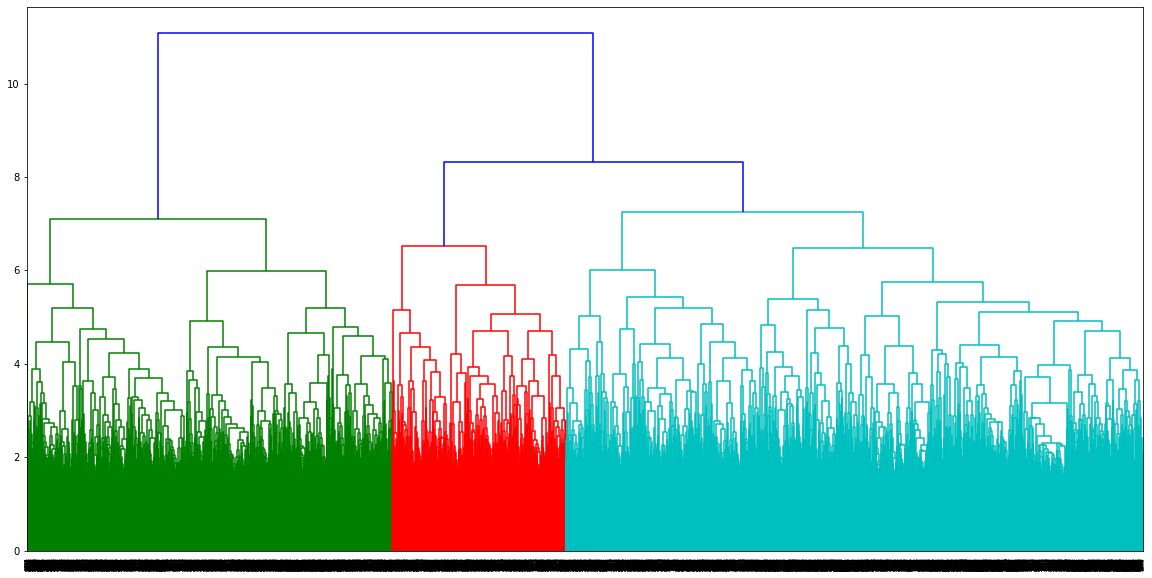

In [ ]:
y = netflix_bag_df['title']
X = netflix_cosine_sim
plt.figure(figsize=(20,10))
dendrogram(linkage(X, method='complete'))
plt.show()

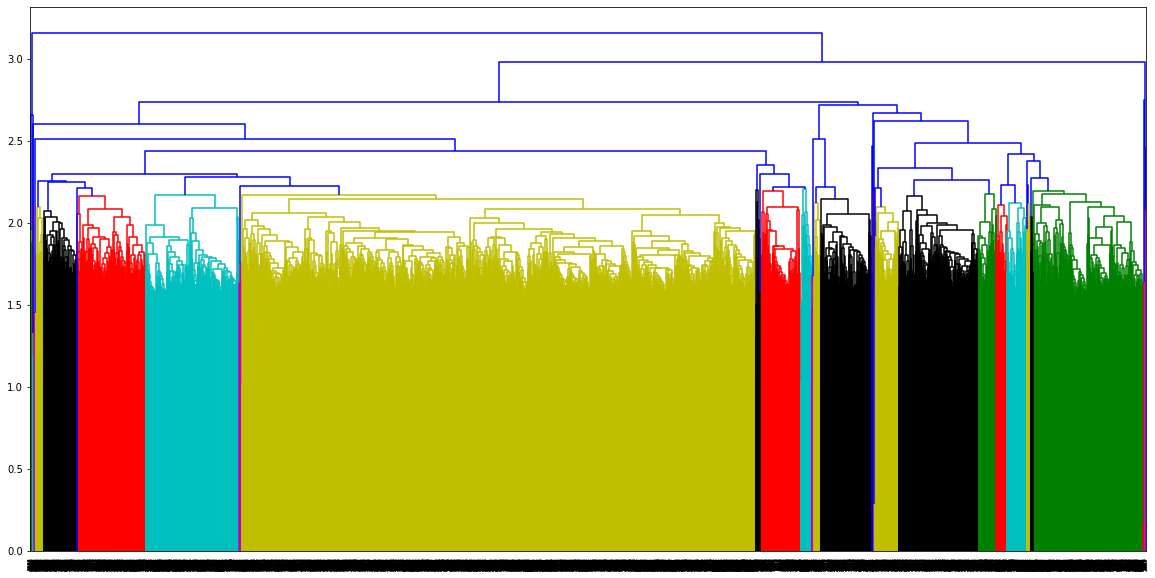

In [ ]:
y = netflix_bag_df['title']
X = netflix_tfidf_sim
plt.figure(figsize=(20,10))
dendrogram(linkage(X, method='complete'))
plt.show()

#The dendrogram on the TF-IDF vectorized data seems to have outperformed the dendrogram on the count vectorized data as it gives us 
# a larger number of groups to pull from for a recommendation. 

### DBSCAN

DBSCAN completely fails to function. It is unable to draw any distinction between the movie titles and groups them all into one group. 

In [ ]:
y = netflix_bag_df['title']
X = netflix_cosine_sim

dbscan_cluster = DBSCAN(eps=1, min_samples=5)

# Fit model
clusters = dbscan_cluster.fit_predict(X)
print(metrics.silhouette_score(X, clusters, metric='euclidean'))
#This model is resulting in only 1 cluster. That is why I am geting this output.

ValueError: ignored

In [ ]:
y = netflix_bag_df['title']
X = netflix_tfidf_sim
dbscan_cluster = DBSCAN(eps=1, min_samples=5)

# Fit model
clusters = dbscan_cluster.fit_predict(X)
print(metrics.silhouette_score(X, clusters, metric='euclidean'))

ValueError: ignored

### Gaussian Mixture Models

In [ ]:
y = netflix_bag_df['title']
X = netflix_cosine_sim

gmm_cluster = GaussianMixture(n_components=3, random_state=123)

clusters = gmm_cluster.fit_predict(X)

print(metrics.silhouette_score(X, clusters, metric='euclidean'))

0.20093508274323993


In [ ]:
y = netflix_bag_df['title']
X = netflix_tfidf_sim
gmm_cluster = GaussianMixture(n_components=3, random_state=123)

clusters = gmm_cluster.fit_predict(X)

print(metrics.silhouette_score(X, clusters, metric='euclidean'))

0.02202162759979657


#Recommender 1 conclusion

The unsupervised tools do not perform well for this task. One problem is in the data type of the 'title' as well as the nature of the data in that column. It is a string, which is not ideal, or even useful, for these models. 

A further problem is what mean by the concept 'group.' In the models provided, the underlying supposition is that there is a group to place the data into. The iris model is a prime example of what is meant by this. There are definitive groups for the data to be split into. With this movie data those groups do not exist. There is not ‘correct’ group to place the movies into as what I am trying to do is group movies based on their similarity to a given movie. 

The best way to evaluate the performance of this recommender is to do some research on the recommended titles and assess how similar they are to the original input. 

One thing to bear in mind about this data is that there is no metric to determine popularity. However, popularity would be a useful piece of information in making a recommender system. It would probably not be super useful to recommend a blockbuster film as most people will have already heard of them and may already have looked them up. An ideal system recommends movies that are similar to the input but not super popular. This way the system increases the likelihood of recommending a movie that the user has not heard of but may be interested in. 
